# Homework 4: Evolutionary solution with BSTC numerical schema

1. When intrusion cools very long time, it has some effect on overall temperature structure of the crust. 

    1. Calculate the temperature evolution of the MOHO temperature during 25 Ma after intrusion. Make plot with 6 geotherms at times 0, 5, 10, 15, 20 and 25 Ma.
    2. Make another plot of time vs. temperature at the MOHO during 25 Ma. You will need to store MOHO temperature **at least** every 100_000 years to have nice plot.
    3. How long after intrusion the maximum temperature at the MOHO will be achieved?
    4. What will be the maximum temperature at MOHO?

2. Create two python functions `init` and `btcs` to calculate steady-state and evolutionary solutions for crustal geotherm with Dirichlet BC at surface and Neumann BC at MOHO.
    1. `init` should take three argumemts: model definition, surface temperature and mantle heatflow `q`. It should return steady-state solution T as numpy array.
    2. `btcs` should take five arguments: model definition, surface temperature, mantle heatflow `q`, initial temperature `T` and time step `dt`. It should return evolutionary solution T as numpy array.

    Use this functions to calculate steady-state solution for same crust as above but with mantle heat flow density 30 mW/m2. In time=0 the mantle heatflow is changed to 36mW/m2 (mantle plume is coming..). Calculate and plot the crustal geotherm after 10 Ma.

In [1]:
from collections import OrderedDict
from typing import TypedDict, NewType, TYPE_CHECKING

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

##  The time independent solution 

In [2]:
T0 = 0                     # The surface temperature.
H = 1e-6                   # The heat production.
k = 2.5                    # The thermal conductivity.
q = -32e-3                 # The mantle heat flow.
n = 200                    # The number of nodes.
th = 35_000                # The crust thickness.

dx = th / (n-1)            # The node spacing.

# The coeficient matrix + conditions.
A = spdiags([np.ones(n) , -2 * np.ones(n) , np.ones(n)], [-1, 0, 1], n, n, 'csr')
A[0, :2] = [1, 0]
A[-1, -2:] = [2, -2]

# The vector of constant terms + conditions.
b = np.ones(n) * (-H * dx**2) / k
b[0] = T0
b[-1] = (q * 2 * dx - H * dx**2) / k

# Solve steady-state eq.
T = spsolve(A, b)

# The node positions (needed only for ploting).
xs = np.linspace(0, th, n) 

# Model the intrusion with temperature 700 °C.
T[(xs >= 10000) & (xs <= 15000)] = 700

# Reverse and scale `xs` for ploting
xs /= -1000

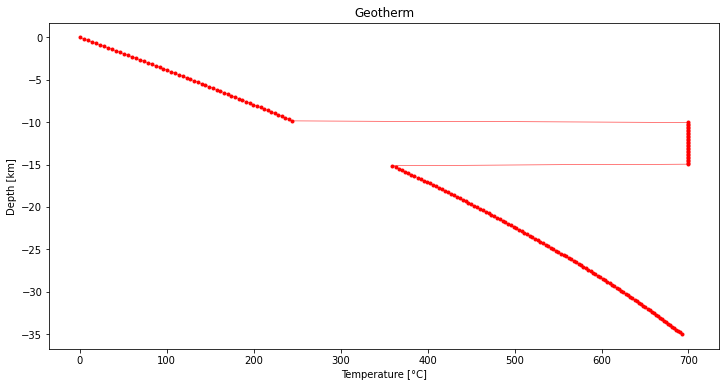

In [3]:
# Check the solution.
plt.figure(figsize=(12, 6))

plt.title('Geotherm')
plt.ylabel('Depth [km]')
plt.xlabel('Temperature [°C]')

plt.plot(T, xs, "r.-", linewidth=0.5)
# plt.legend()

plt.show()

## The time dependent solution

In [4]:
# Using parameters from the previous example: H, k, q, n, tx, dx, xs, x and d helper.

# Material propetries.
𝜌 = 2700                   # The density of rock.
c = 900                    # The specific heat capacity.
κ = k / (𝜌 * c)            # The thermal diffusivity.

# Helper CONSTANT
YEAR_IN_SECONDS = 365.25 * 24 * 3600  # The one year in seconds.

ys = 25_000_000            # The time span in years.
ts = 50_000                # The time step in years.
dt = ts * YEAR_IN_SECONDS  # Time step in seconds.

# The coeficient matrix + condtion.
u = κ * dt / dx**2
A = spdiags([-np.ones(n) * u, 1 + 2 * np.ones(n) * u, -np.ones(n) * u], [-1, 0, 1], n, n, 'csr')
A[0,:2] = [1,0]
A[-1,-2:] = [-2 * u, 1 + 2 * u]

# The vector of constant terms + conditions.
b = np.ones(n) * H * dt / (𝜌 * c)
b[0] = 0
b[-1] -= 2 * dt * q / (𝜌 * c * dx)

# Keep the years and temperatures tied together. 
Ts = OrderedDict({0: T.copy()})

# Solve the time-dependent eq.; The number of steps is `ys // ts`.
# Note: When the memory is problem, we can store only arrays for 0,  5, 10, 15, 20, 25my and skip other.
for i in range(ys // ts): 
    # Get the last stored temperatuer field and caclucalte the new one.
    Ts[i * ts + ts] = spsolve(A, b + list( Ts.items() )[-1][1] )   

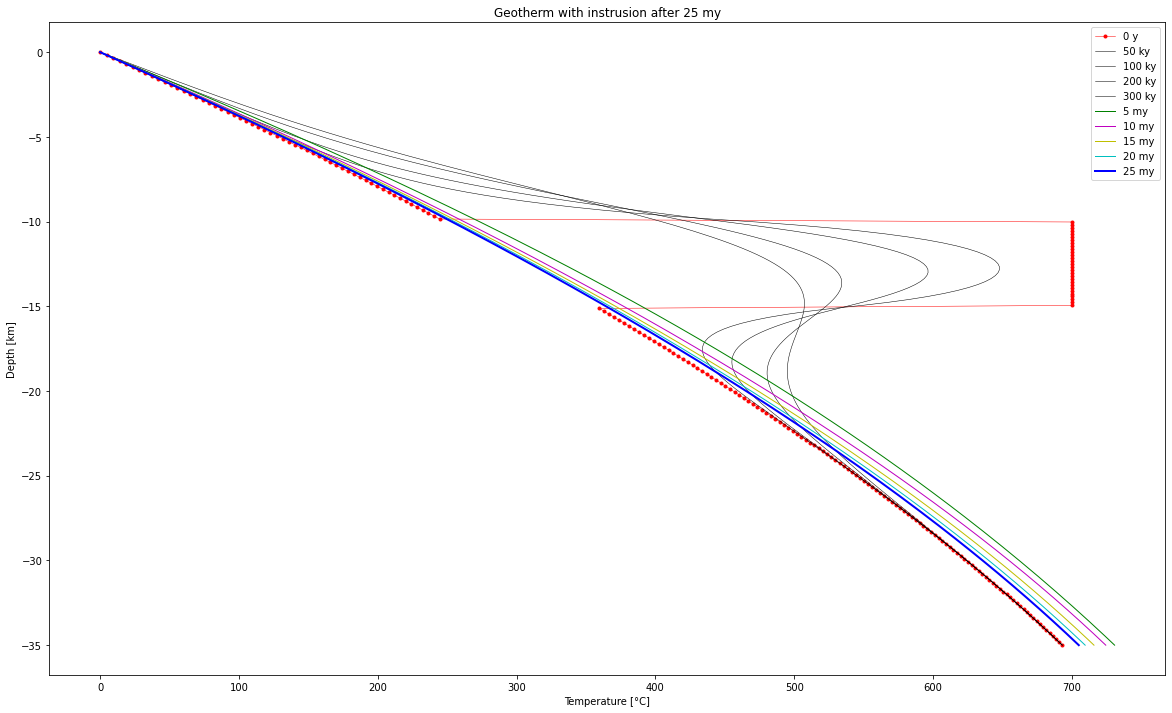

In [5]:
# Check the solution for 0,  5, 10, 15, 20, 25my.
plt.figure(figsize=(20, 12))

plt.ylabel('Depth [km]')
plt.xlabel('Temperature [°C]')
plt.title(f'Geotherm with instrusion after {ys // 10**6} my')

# Check values.
plt.plot(Ts[0],    xs, 'r.-', label='0 y', linewidth=0.5)
plt.plot(Ts[5e4],  xs, 'k-', label='50 ky', linewidth=0.5)
plt.plot(Ts[1e5],  xs, 'k-', label='100 ky', linewidth=0.5)
plt.plot(Ts[2e5],  xs, 'k-', label='200 ky', linewidth=0.5)
plt.plot(Ts[3e5],  xs, 'k-', label='300 ky', linewidth=0.5)

# Homework values.
plt.plot(Ts[5e6],  xs, 'g-', label='5 my', linewidth=1.0)
plt.plot(Ts[10e6], xs, 'm-', label='10 my', linewidth=1.0)
plt.plot(Ts[15e6], xs, 'y-', label='15 my', linewidth=1.0)
plt.plot(Ts[20e6], xs, 'c-', label='20 my', linewidth=1.0)
plt.plot(Ts[25e6], xs, 'b-', label='25 my', linewidth=2.0)

plt.legend()

plt.show() # Without the  show() the notebook prints the last matplotlib object to the output.

The maximum temperature at MOHO is 730.8473118436802 °C, 5450000 years after the intrusion.


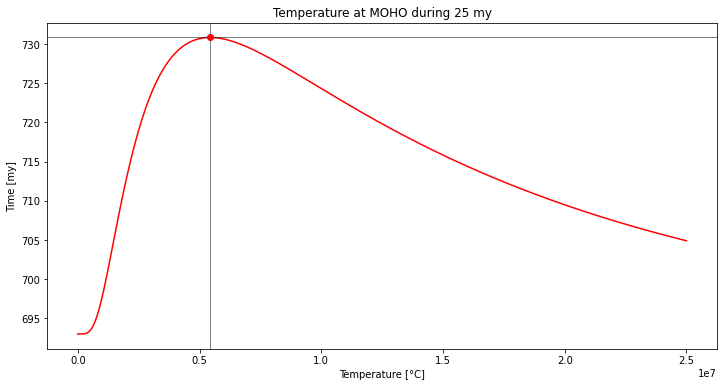

In [6]:
years, Tm = [], [] # years, temperatures at MOHO
for k, v in Ts.items():
    years.append(k)
    Tm.append(v[-1])

# Maybe better strategy is to find maximum by finding minimum derivative.
# from scipy.optimize import fmin
# scipy.optimize.fmin(-f)
Tmax, Ymax = np.array(Tm).max(), np.array(Tm).argmax() * ts

print(f"The maximum temperature at MOHO is {Tmax} °C, {Ymax} years after the intrusion.")

plt.figure(figsize=(12, 6))

plt.ylabel('Time [my]')
plt.xlabel('Temperature [°C]')
plt.title(f'Temperature at MOHO during {ys // 10**6} my')

plt.plot(years, Tm, 'r-', label='0y')
plt.axvline(Ymax, color="k", linewidth=0.5)
plt.axhline(Tmax, color="k", linewidth=0.5)
plt.plot(Ymax, Tmax, "ro")

plt.show() 

In [7]:
# Když nic, tak aspoň editor upozorní, že někde dosazujeme `H` za `q`, ale nezabrání např. `H` + `q`.

Density = NewType("Density", float)
HeatFlow = NewType("HeatFlow", float)
Conductivity = NewType("Conductivity", float)
Temperature = NewType("Temperature", float)
SpecificHeat = NewType("SpecificHeat", float)
HeatProduction = NewType("HeatProduction", float) 


class Parameters(TypedDict):
    """
    The model parameters.
    """
    H: HeatProduction
    k: Conductivity       
    c: SpecificHeat
    n: int          # The number of nodes in discretized domain.
    d: int          # The crustall thickeness in km.
    𝜌: Density 

In [8]:
def init(params: Parameters, T0: Temperature, q: HeatFlow, time_step:float) -> np.array:
    """
    The time independent solution to heat equation.

    :param params:    The model parameters.
    :param T0:        The surface temperature [°C].
    :param q:         The mantle heat flow density [mW/m^2].
    :param time_step: The time step in years.
    :returns:         The temperature field [°C].
    """
    H, k, n, d, _, _ = params.values()
    q = - abs(q) # Always negative => "blbuvzdorný"
                 
    # Setup the domain.
    dx = d / (n - 1)          # The node spacing.
    dt = time_step * YEAR_IN_SECONDS # The time step in seconds.

    # The coeficient matrix + condistions.
    A = spdiags([np.ones(n), -2 * np.ones(n), np.ones(n)], [-1, 0, 1], n, n, 'csr')
    
    A[0, :2] = [1, 0]
    A[-1, -2:] = [2, -2]

    # The vector of constant terms + conditions.
    b = np.ones(n) * (-H * dx**2) / k
    b[0] = T0
    b[-1] = (q * 2 * dx - H * dx**2) / k
    
    return spsolve(A, b)

In [9]:
def btcs(params: dict, q: HeatFlow, T: np.array, time_span: float, time_step: float) -> np.array:
    """
    The time dependent solution to heat equation.

    :param params:    The model parameters.
    :param q:         The mantle heat flow.
    :param T:         The initial temperatures [°C].
    :param time_step: The time step in years.
    :param time_span: The time span in years.
    
    :returns:      The temperature field [°C].
    """
    H, k, n, d, 𝜌, c = params.values()
    q = - abs(q) # Always negative => "blbuvzdorný"

    dx = d / (n - 1)          # The node spacing.
    x = np.linspace(0, d, n)  # The node positions.
    
    κ = k / (𝜌 * c)           # The thermal diffusivity.
    dt = time_step * YEAR_IN_SECONDS # Time step in seconds.
    
    # The coeficient matrix + condtion.
    u = κ * dt / dx**2
    A = spdiags([-np.ones(n) * u, 1 + 2 * np.ones(n) * u, -np.ones(n) * u], [-1, 0, 1], n, n, 'csr')
    A[0,:2] = [1,0]
    A[-1,-2:] = [-2 * u, 1 + 2 * u]

    # The vector of constant terms + conditions.
    b = np.ones(n) * H * dt / (𝜌 * c)
    b[0] = 0
    b[-1] -= 2 * dt * q / (𝜌 * c * dx)
    
    Ts = T.copy()
    for i in range(time_span // time_step): 
        # Get the last stored temperatuer field and caclucalte the new one.
        Ts = spsolve(A, b + Ts)

    return Ts

In [10]:
params: Parameters = dict(H=1e-6, k=2.5, n=200, d=35000, 𝜌=2700, c=900)      

T_zero = init(params, T0=0, q=-30e-3, time_step=50_000)
T_moho = btcs(params, q=-36e-3, T = T_zero, time_step=50_000, time_span=10_000_000)

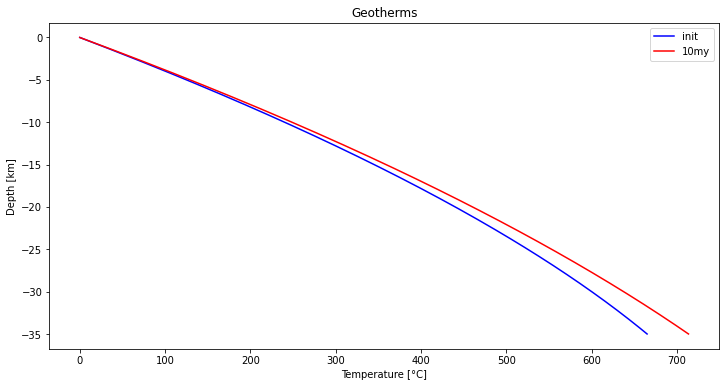

In [11]:
# Check the solution.
plt.figure(figsize=(12, 6))

plt.ylabel('Depth [km]')
plt.xlabel('Temperature [°C]')
plt.title(f'Geotherms')

plt.plot(T_zero,  xs, 'b-', label='init')
plt.plot(T_moho,  xs, 'r-', label='10my')
plt.legend()

plt.show()